In [ ]:

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
data.dtypes

review       object
sentiment    object
dtype: object

In [ ]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
data.isnull()

,review,sentiment
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
49995,False,False
49996,False,False
49997,False,False
49998,False,False


In [ ]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
data.isnull().values.any()



False

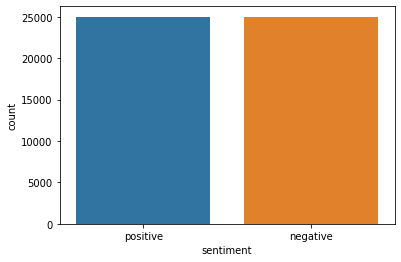

In [ ]:
import seaborn as sns

sns.countplot(x='sentiment', data=data)

In [ ]:
data.shape

(50000, 2)

In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
LE = LabelEncoder()
OE= OneHotEncoder()
data['sentiment'] = LE.fit_transform(data['sentiment'])
print(data['sentiment'].unique())
print(data['sentiment'].shape)


[1 0]
(50000,)


In [ ]:
pip install wordcloud matplotlib

In [ ]:
print("Categories:", np.unique(data['sentiment']))
print("Number of unique words:", len(np.unique(np.hstack(data))))


length = [len(i) for i in data]
print("Average Review length:", np.mean(length))
print("Standard Deviation:", round(np.std(length)))



Categories: ['negative' 'positive']
Number of unique words: 2
Average Review length: 7.5
Standard Deviation: 2


In [ ]:
from sklearn.model_selection import train_test_split
X=data['review']
y=data['sentiment']



Number of words: 
49582
Review length: 
Mean 1309.43 words (989.718117)


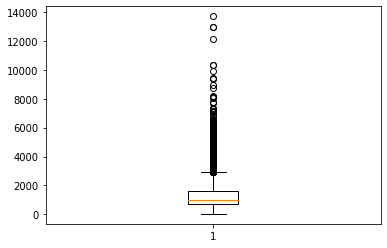

In [ ]:
from matplotlib import pyplot
print("Number of words: ")
print(len(np.unique(np.hstack(X))))
print("Review length: ")
result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
pyplot.boxplot(result)
pyplot.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print(X_train.shape,y_train.shape,X_val.shape)
print(X_test.shape,y_test.shape,y_val.shape)

(30000,) (30000,) (10000,)
(10000,) (10000,) (10000,)


In [ ]:

tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
print(data['review'])

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object


In [ ]:
from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize("""Hello Mr. Smith, how are you doing today? The weather is great, and city is awesome.
The sky is pinkish-blue. You shouldn't eat cardboard""")
print(tokenized_word)

['Hello', 'Mr.', 'Smith', ',', 'how', 'are', 'you', 'doing', 'today', '?', 'The', 'weather', 'is', 'great', ',', 'and', 'city', 'is', 'awesome', '.', 'The', 'sky', 'is', 'pinkish-blue', '.', 'You', 'should', "n't", 'eat', 'cardboard']


In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
data['review']=data['review'].apply(denoise_text)

In [ ]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
data['review']=data['review'].apply(remove_special_characters)

In [ ]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
data['review']=data['review'].apply(simple_stemmer)

In [ ]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
data['review']=data['review'].apply(remove_stopwords)

{'are', 'shan', 'as', "needn't", 'didn', 'will', "shan't", "wouldn't", 'most', 'wasn', "you'll", 'himself', 'themselves', 'couldn', 'few', 'up', 'my', "isn't", 'his', 'above', "shouldn't", 'or', 'isn', 'these', 'him', 'then', 'mightn', 'after', 'can', 'have', 'no', "it's", "you've", 'more', 'ma', 'because', 'herself', 'some', "won't", 'been', 'is', 'has', 'it', 'each', 's', 'i', 'they', 'don', 'and', "mustn't", 'with', 'again', 'weren', "weren't", 'm', 'than', 'aren', 'we', 'how', 'does', 'them', 're', 'that', 'at', 'having', 'from', 'in', 'further', 'very', 'ours', 'now', 'own', 've', 'your', 'myself', 't', 'am', 'he', "she's", 'any', 'so', 'here', 'same', "hadn't", 'just', 'me', "that'll", 'to', 'were', 'her', 'between', 'should', 'for', 'itself', 'what', 'ourselves', 'there', 'into', 'why', 'about', "hasn't", 'theirs', 'which', 'did', "you're", 'you', 'being', 'their', 'doing', 'was', 'both', "didn't", 'during', 'who', 'had', 'whom', 'if', 'by', 'hadn', 'over', 'll', 'our', 'doesn',

In [ ]:
#normalized train reviews
norm_train_reviews=X_train
norm_train_reviews[0]


"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
#Normalized test reviews
norm_test_reviews=X_test
norm_test_reviews[35067]


"I thought maybe... maybe this could be good. An early appearance by the Re-Animator (Jeffery Combs); many homage's to old horror movies; the Troma label on the front\x85 this movie could be a gem! I thought wrong.<br /><br />Frightmare is a boring, overplayed, half assed homage to the fright films of yore. The story is an old one, young people breaking into a house, getting drunk, making love, and tampering with things that shouldn't be tampered with. The oft \x96 recycled slasher film formula is used here, this time with a thought to be dead actor named Conrad Radzoff doing the killing. In fact, the performance by the Radzoff's actor Ferdy Mayne is the only redeeming quality of this film. He does the snooty Dracula style character very well. But as for the kids, its not so good, with Combs only having a minimal part.<br /><br />The film lacks entertainment value, and only features one cool character, and one or two scenes that can hold your attention. I do not recommend this film unl

In [ ]:
norm_val_reviews=X_val
norm_val_reviews[10335]

'At the end of the film I just asked myself :"is it the worse movie I have ever seen or is it the worse movie I have ever seen ?". And the answer is... Actually, after having seen this movie and thought a bit about the meaning of it, you just can\'t find any meaning and you can only remember the two rape scenes, which are unbelievably brutal and useless. It seems to me as if the director tried to push this question into the crowd\'s head : "what are such crimes compared to horror of war and extermination ?" because i noticed that the two awful scenes where directly connected to war and it\'s horrors (during the first scene you can here the girl that is being raped screaming and in the same time you hear one of president Bush\'s speeches about the necessity of starting a war with Iraq and in the second scene, the pictures of the three criminals sticking a sword in a woman\'s vagina, are directly followed by archive pictures of World war II. But as a matter of facts, i really could not t

In [ ]:

cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
cv_train_reviews=cv.fit_transform(norm_train_reviews)
cv_test_reviews=cv.transform(norm_test_reviews)
cv_val_reviews=cv.transform(norm_val_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
print('BOW_cv_val:',cv_val_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (30000, 4918988)
BOW_cv_test: (10000, 4918988)
BOW_cv_val: (10000, 4918988)


In [ ]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
tv_val_reviews=tv.transform(norm_val_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)
print('Tfidf_val:',tv_val_reviews.shape)

Tfidf_train: (30000, 4918988)
Tfidf_test: (10000, 4918988)
Tfidf_val: (10000, 4918988)


In [ ]:
#word cloud for positive review words
import matplotlib.pyplot as plt
from wordcloud import WordCloud
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

In [ ]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

In [ ]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,y_train)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,y_train)
print(lr_tfidf)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_val_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_val_reviews)
print(lr_tfidf_predict)

['negative' 'positive' 'positive' ... 'positive' 'positive' 'negative']
['negative' 'positive' 'positive' ... 'positive' 'positive' 'positive']


In [ ]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score( y_val,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score( y_val,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)


lr_bow_score : 0.7622
lr_tfidf_score : 0.7582


In [ ]:
#Classification report for bag of words 
lr_bow_report=classification_report(y_val,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(y_val,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.77      0.74      0.76      5024
    Negative       0.75      0.78      0.77      4976

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

              precision    recall  f1-score   support

    Positive       0.79      0.70      0.75      5024
    Negative       0.73      0.81      0.77      4976

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



In [ ]:

#confusion matrix for bag of words
cm_bow=confusion_matrix(y_val,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(y_val,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3881 1095]
 [1283 3741]]
[[4043  933]
 [1485 3539]]


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,lr_bow_predict)
auc_roc

0.7622847630409405

In [ ]:
y_prob = lr.predict_proba(cv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
lr.score(cv_val_reviews, y_pred)

1.0

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.840262279642923

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,lr_tfidf_predict)
auc_roc

0.7584593949044586

In [ ]:
y_prob = lr.predict_proba(tv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
lr.score(tv_val_reviews, y_pred)

1.0

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7584593949044586

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
#training the linear svm
svm=SGDClassifier(loss='log',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,y_train)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,y_train)
print(svm_tfidf)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=500,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=500,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [ ]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_val_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_val_reviews)
print(svm_tfidf_predict)

[0 1 1 ... 1 1 1]
[0 1 1 ... 1 1 1]


In [ ]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(y_val,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(y_val,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.7584
svm_tfidf_score : 0.6935


In [ ]:
#Classification report for bag of words 
svm_bow_report=classification_report(y_val,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(y_val,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.79      0.70      0.74      5024
    Negative       0.73      0.82      0.77      4976

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

              precision    recall  f1-score   support

    Positive       0.88      0.45      0.60      5024
    Negative       0.63      0.94      0.75      4976

    accuracy                           0.69     10000
   macro avg       0.75      0.69      0.67     10000
weighted avg       0.75      0.69      0.67     10000



In [ ]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(y_val,svm_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(y_val,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4062  914]
 [1502 3522]]
[[4662  314]
 [2751 2273]]


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,svm_bow_predict)
auc_roc

0.7586766799107052

In [ ]:
y_prob = svm.predict_proba(cv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
svm.score(cv_val_reviews, y_pred)

1.0

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,svm_tfidf_predict)
auc_roc

0.6946627250291847

In [ ]:
y_prob = svm.predict_proba(tv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
svm.score(tv_val_reviews, y_pred)

1.0

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8417521939705491

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,y_train)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,y_train)
print(mnb_tfidf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [ ]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_val_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_val_reviews)
print(mnb_tfidf_predict)

[0 1 1 ... 1 1 0]
[0 1 1 ... 1 1 0]


In [ ]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(y_val,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(y_val,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.7631
mnb_tfidf_score : 0.7624


In [ ]:
#Classification report for bag of words 
mnb_bow_report=classification_report(y_val,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(y_val,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.76      0.76      0.76      5024
    Negative       0.76      0.76      0.76      4976

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

              precision    recall  f1-score   support

    Positive       0.77      0.74      0.76      5024
    Negative       0.75      0.78      0.77      4976

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



In [ ]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(y_val,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(y_val,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3790 1186]
 [1183 3841]]
[[3885 1091]
 [1285 3739]]


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,mnb_bow_predict)
auc_roc

0.7630931016650623

In [ ]:
y_prob = mnb.predict_proba(cv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
mnb.score(cv_val_reviews, y_pred)

1.0

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, mnb_tfidf_predict)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7624876477154033

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,mnb_tfidf_predict)
auc_roc

0.7624876477154033

In [ ]:
y_prob = mnb.predict_proba(tv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
mnb.score(tv_val_reviews, y_pred)

1.0

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,mnb_tfidf_predict)
auc_roc

0.7624876477154033

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % auc_roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(cv_train_reviews, y_train)




KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn.fit(tv_train_reviews, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
pred = knn.predict(cv_val_reviews)
predtv=knn.predict(tv_val_reviews)

In [ ]:
print(pred)

[0 1 0 ... 0 0 0]


In [ ]:
print(predtv)

[0 0 0 ... 0 0 0]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val ,pred))
print(classification_report(y_val ,predtv))

              precision    recall  f1-score   support

           0       0.51      0.85      0.63      5024
           1       0.52      0.16      0.25      4976

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.44     10000
weighted avg       0.51      0.51      0.44     10000

              precision    recall  f1-score   support

           0       0.50      0.85      0.63      5024
           1       0.50      0.15      0.24      4976

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.43     10000
weighted avg       0.50      0.50      0.44     10000



In [ ]:
cm_bow=confusion_matrix(y_val,pred,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(y_val,predtv,labels=[1,0])
print(cm_tfidf)

[[ 817 4159]
 [ 762 4262]]
[[ 768 4208]
 [ 759 4265]]


In [ ]:
knn_bow_score=accuracy_score(y_val,pred)
print("knn_bow_score :",knn_bow_score)
#Accuracy score for tfidf features
knn_tfidf_score=accuracy_score(y_val,predtv)
print("knn_tfidf_score :",knn_tfidf_score)

knn_bow_score : 0.5079
knn_tfidf_score : 0.5033


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,pred)
auc_roc

0.5062580641857989

In [ ]:
y_prob = knn.predict_proba(cv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
knn.score(cv_val_reviews, y_pred)

1.0

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5101273733346816

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
y_prob = knn.predict_proba(tv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
knn.score(tv_val_reviews, y_pred)

1.0

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5009371815926639

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
from sklearn.svm import SVC 
svclassifier = SVC(kernel='rbf', degree=8,probability=True)
svclassifier.fit(cv_train_reviews, y_train) 


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=8, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred = svclassifier.predict(cv_val_reviews)

In [ ]:
print(y_pred)

[0 0 0 ... 0 0 0]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred))


[[5023    1]
 [4940   36]]


In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      5024
           1       0.97      0.01      0.01      4976

    accuracy                           0.51     10000
   macro avg       0.74      0.50      0.34     10000
weighted avg       0.74      0.51      0.34     10000



In [ ]:
from sklearn.svm import SVC 
svclassifier = SVC(kernel='rbf', degree=8,probability=True)
svclassifier.fit(tv_train_reviews, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=8, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_predtv = svclassifier.predict(tv_val_reviews)

In [ ]:
print(y_predtv)

[1 1 1 ... 1 1 1]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_predtv))

[[  75 4949]
 [   6 4970]]


In [ ]:
print(classification_report(y_val, y_predtv))

              precision    recall  f1-score   support

           0       0.93      0.01      0.03      5024
           1       0.50      1.00      0.67      4976

    accuracy                           0.50     10000
   macro avg       0.71      0.51      0.35     10000
weighted avg       0.71      0.50      0.35     10000



In [ ]:
svm_bow_score=accuracy_score(y_val,y_pred)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(y_val,y_predtv)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.5097
svm_tfidf_score : 0.5045


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,y_pred)
auc_roc

0.5035178410510578

In [ ]:
y_prob = svclassifier.predict_proba(cv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
svclassifier.score(cv_val_reviews, y_pred)

0.9918

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6043063632186085

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,y_predtv)
auc_roc

0.5068612780838471

In [ ]:
y_prob = svclassifier.predict_proba(tv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
svclassifier.score(tv_val_reviews, y_pred)

0.4886

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8147970529240994

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:

# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(cv_train_reviews, y_train)

  

In [ ]:
y_pred = clf.predict(cv_val_reviews)
  

In [ ]:
print(y_pred)

[0 0 0 ... 0 0 0]


In [ ]:
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_val, y_pred))


ACCURACY OF THE MODEL:  0.5059


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[5022    2]
 [4939   37]]


In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      5024
           1       0.95      0.01      0.01      4976

    accuracy                           0.51     10000
   macro avg       0.73      0.50      0.34     10000
weighted avg       0.73      0.51      0.34     10000



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,y_pred)
auc_roc

0.5035188010731767

In [ ]:
y_prob = clf.predict_proba(cv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
clf.score(cv_val_reviews, y_pred)

1.0

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7129462462815143

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(tv_train_reviews, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_predtv = clf.predict(tv_val_reviews)

In [ ]:
print(y_predtv)

[0 0 0 ... 0 0 0]


In [ ]:
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_val, y_predtv))


ACCURACY OF THE MODEL:  0.5061


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_predtv))

[[5024    0]
 [4939   37]]


In [ ]:
print(classification_report(y_val, y_predtv))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      5024
           1       1.00      0.01      0.01      4976

    accuracy                           0.51     10000
   macro avg       0.75      0.50      0.34     10000
weighted avg       0.75      0.51      0.34     10000



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,y_predtv)
auc_roc

0.503717845659164

In [ ]:
y_prob = clf.predict_proba(tv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
clf.score(tv_val_reviews, y_pred)

1.0

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7164166062386077

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
import warnings
warnings.filterwarnings('ignore') 

In [ ]:
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier
seed = 7
num_trees = 5
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, cv_train_reviews, y_train, cv=kfold)
print(results.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.5022666666666666


In [ ]:
model.fit(cv_train_reviews,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=5, random_state=7)

In [ ]:
y_pred = model.predict(cv_val_reviews)

In [ ]:
print(y_pred)

[1 1 1 ... 1 1 1]


In [ ]:
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_val, y_pred))


ACCURACY OF THE MODEL:  0.4977


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[   1 5023]
 [   0 4976]]


In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      5024
           1       0.50      1.00      0.66      4976

    accuracy                           0.50     10000
   macro avg       0.75      0.50      0.33     10000
weighted avg       0.75      0.50      0.33     10000



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,y_pred)
auc_roc

0.5000995222929936

In [ ]:
y_prob = model.predict_proba(cv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
model.score(cv_val_reviews, y_pred)

1.0

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5000995222929936

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier
seed = 7
num_trees = 5
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, tv_train_reviews, y_train, cv=kfold)
print(results.mean())

0.5022666666666666


In [ ]:
model.fit(tv_train_reviews,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=5, random_state=7)

In [ ]:
print(y_pred)

[1 1 1 ... 1 1 1]


In [ ]:
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_val, y_pred))


ACCURACY OF THE MODEL:  0.4977


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[   1 5023]
 [   0 4976]]


In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      5024
           1       0.50      1.00      0.66      4976

    accuracy                           0.50     10000
   macro avg       0.75      0.50      0.33     10000
weighted avg       0.75      0.50      0.33     10000



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,y_pred)
auc_roc

0.5000995222929936

In [ ]:
y_prob = model.predict_proba(tv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
model.score(tv_val_reviews, y_pred)

1.0

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5000995222929936

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

kfold = model_selection.KFold(n_splits=10,)
# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier(max_depth=3)
estimators.append(('cart', model2))
model3 = LinearSVC()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, cv_train_reviews , y_train, cv=kfold)
print(results.mean())

0.4977333333333333


In [ ]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

kfold = model_selection.KFold(n_splits=10,)
# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier(max_depth=3)
estimators.append(('cart', model2))
model3 = LinearSVC()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, tv_train_reviews , y_train, cv=kfold)
print(results.mean())

0.5022666666666666


In [ ]:

from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(cv_train_reviews, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:

# make predictions for test data
y_pred = model.predict(cv_val_reviews)


In [ ]:
print(y_pred)

[1 1 1 ... 1 1 1]


In [ ]:
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_val, y_pred))


ACCURACY OF THE MODEL:  0.4976


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[   0 5024]
 [   0 4976]]


In [ ]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5024
           1       0.50      1.00      0.66      4976

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,y_pred)
auc_roc

0.5

In [ ]:
y_prob = model.predict_proba(cv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
model.score(tv_val_reviews, y_pred)

1.0

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
model = XGBClassifier()
model.fit(tv_train_reviews, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = model.predict(tv_val_reviews)


In [ ]:
print(y_pred)

[1 1 1 ... 1 1 1]


In [ ]:
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_val, y_pred))


ACCURACY OF THE MODEL:  0.4976


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[   0 5024]
 [   0 4976]]


In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5024
           1       0.50      1.00      0.66      4976

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,y_pred)
auc_roc

0.5

In [ ]:
y_prob = model.predict_proba(tv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
model.score(tv_val_reviews, y_pred)

1.0

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
model.fit(cv_train_reviews, y_train)
model.score(cv_val_reviews,y_val)


0.498

In [ ]:
y_pred = model.predict(cv_val_reviews)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[  12 5012]
 [   8 4968]]


In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.00      0.00      5024
           1       0.50      1.00      0.66      4976

    accuracy                           0.50     10000
   macro avg       0.55      0.50      0.33     10000
weighted avg       0.55      0.50      0.33     10000



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,y_pred)
auc_roc

0.5003904089950233

In [ ]:
y_prob = model.predict_proba(cv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
model.score(cv_val_reviews, y_pred)

1.0

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5003905689987097

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
model.fit(tv_train_reviews ,y_train)
model.score(tv_val_reviews,y_val)



0.498

In [ ]:
y_pred = model.predict(tv_val_reviews)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[  12 5012]
 [   8 4968]]


In [ ]:
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.60      0.00      0.00      5024
           1       0.50      1.00      0.66      4976

    accuracy                           0.50     10000
   macro avg       0.55      0.50      0.33     10000
weighted avg       0.55      0.50      0.33     10000



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_val,y_pred)
auc_roc

0.5003904089950233

In [ ]:
y_prob = model.predict_proba(tv_val_reviews)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
model.score(tv_val_reviews, y_pred)

1.0

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5003905689987097

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')